# Task 2.1

## Generate noisy 1D data

### Generate _true_ data

In [ ]:
import numpy as np
from numpy.random import default_rng
from scipy.interpolate import CubicSpline

dots_number = 6
dots_range = 5

rng = default_rng()
x = np.linspace(0, (dots_number-1)*dots_range, num=dots_number)
y = rng.standard_normal(dots_number)*10
spl = CubicSpline(x, y)

### Let's see what we got

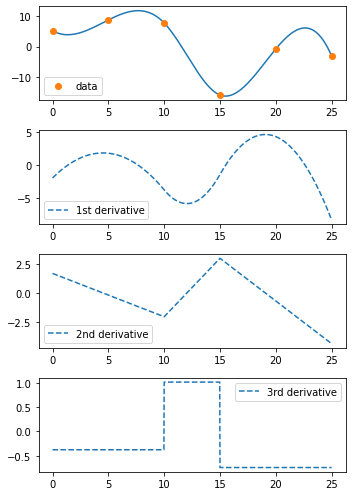

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4, 1, figsize=(5, 7))
xnew = np.linspace(0, (dots_number-1)*dots_range, num=1001)
ax[0].plot(xnew, spl(xnew))
ax[0].plot(x, y, 'o', label='data')
ax[1].plot(xnew, spl(xnew, nu=1), '--', label='1st derivative')
ax[2].plot(xnew, spl(xnew, nu=2), '--', label='2nd derivative')
ax[3].plot(xnew, spl(xnew, nu=3), '--', label='3rd derivative')
for j in range(4):
    ax[j].legend(loc='best')
plt.tight_layout()
plt.show()

### Now give it some normal noize

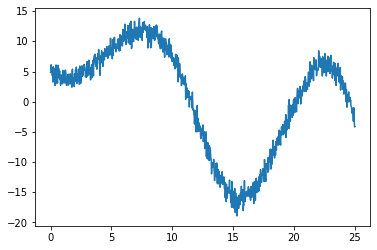

In [ ]:
noize_sigma = 1

measurement = [value + rng.normal()*noize_sigma for value in spl(xnew)]
plt.plot(xnew, measurement)

## Demonstrate 1D Linear Kalman Filter estimation on data

### Create Filter

In [20]:
!pip install filterpy

     |████████████████████████████████| 177 kB 501 kB/s eta 0:00:01
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110451 sha256=ef3d197a9751c167709ab474278d54531bef05542cc2940c9af232ef231cfac5
  Stored in directory: /home/genom10/.cache/pip/wheels/fe/f6/cb/40331472edf4fd399b8cad02973c6acbdf26898342928327fe
Successfully built filterpy


In [ ]:
from filterpy.kalman import KalmanFilter
import filterpy
filter = KalmanFilter(dim_x=3, dim_z=1)

dt = xnew[1] - xnew[0]


# System behaviour matrix
filter.F = np.array([[1,   dt,     (dt**2)/2],
                     [0,   1.0,    dt],
                     [0,   0,      1.0]])

# Observational matrix
filter.H = np.array([[1.0, 0.0, 0.0]])

# Noise destribution
filter.R = np.array([[noize_sigma*noize_sigma]])

# 
filter.Q = filterpy.common.Q_discrete_white_noise(dim=3, dt=dt) 

# How little we trust initial estimation (larger number -> less trust)  # eOPt
filter.P = np.array([[10.0, 0.0,  0.0],
                    [0.0,  10.0, 0.0],
                    [0.0,  0.0,  10.0]])

# Initial tate                                                          # xOpt
filter.x = np.array([0.0, 0.0, 0.0]) 

### Filter generated data 

In [ ]:
kalman = []
stateCovarianceHistory = []

for i in range(0, len(measurement)):
   z = [ measurement[i] ]                      # Вектор измерений
   filter.predict()                            # Этап предсказания
   filter.update(z)                            # Этап коррекции

   kalman.append(filter.x)
   stateCovarianceHistory.append(filter.P)

kalman = np.array(kalman)
stateCovarianceHistory = np.array(stateCovarianceHistory)

### Visualisation

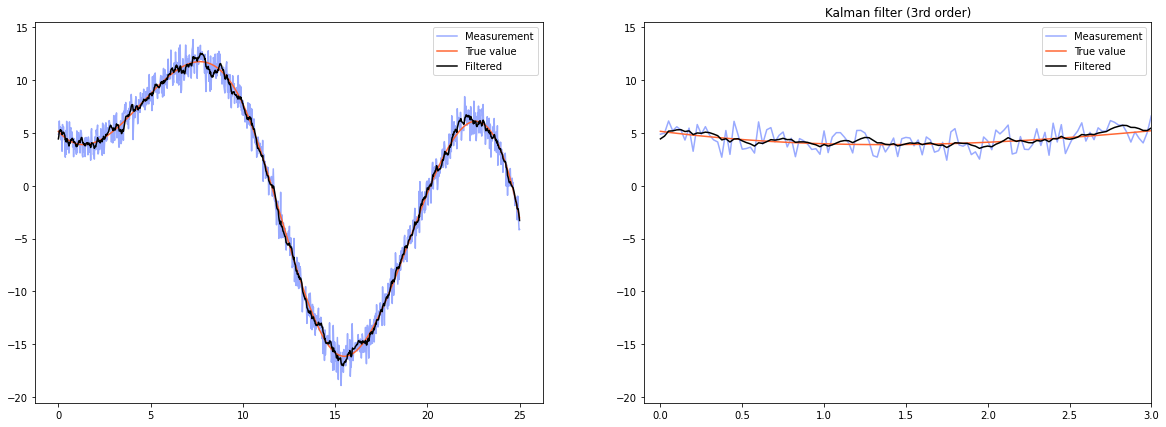

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
plt.title("Kalman filter (3rd order)")
ax[0].plot(xnew, measurement, label="Measurement", color="#99AAFF")
ax[0].plot(xnew, spl(xnew), label="True value", color="#FF6633")
ax[0].plot(xnew, kalman[:, 0], label="Filtered", color="k")
ax[0].legend()

ax[1].plot(xnew, measurement, label="Measurement", color="#99AAFF")
ax[1].plot(xnew, spl(xnew), label="True value", color="#FF6633")
ax[1].plot(xnew, kalman[:, 0], label="Filtered", color="k")
ax[1].legend()
ax[1].set_xlim((-0.1,3))

plt.show()

## Create simplified recursive filter and compare its results with 1D Kalman filter

### Filtering data out

In [ ]:
recursive = [0]
sensorTrust = 0.2
for data in measurement:
  recursive.append((recursive[-1] * (1-sensorTrust)) + (data * sensorTrust))

### Plotting

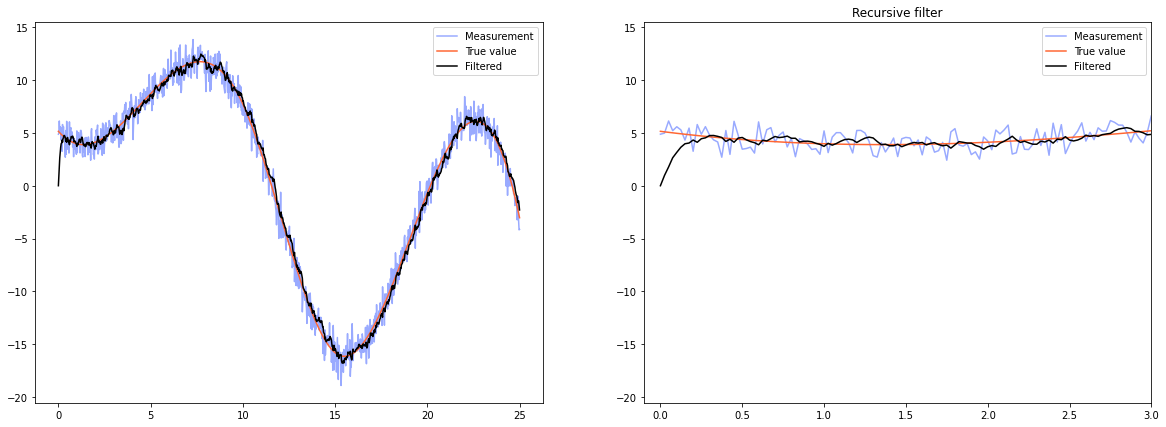

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
plt.title("Recursive filter")
ax[0].plot(xnew, measurement, label="Measurement", color="#99AAFF")
ax[0].plot(xnew, spl(xnew), label="True value", color="#FF6633")
ax[0].plot(xnew, recursive[:len(xnew)], label="Filtered", color="k")
ax[0].legend()

ax[1].plot(xnew, measurement, label="Measurement", color="#99AAFF")
ax[1].plot(xnew, spl(xnew), label="True value", color="#FF6633")
ax[1].plot(xnew, recursive[:len(xnew)], label="Filtered", color="k")
ax[1].legend()
ax[1].set_xlim((-0.1,3))

plt.show()

## Compare the performance

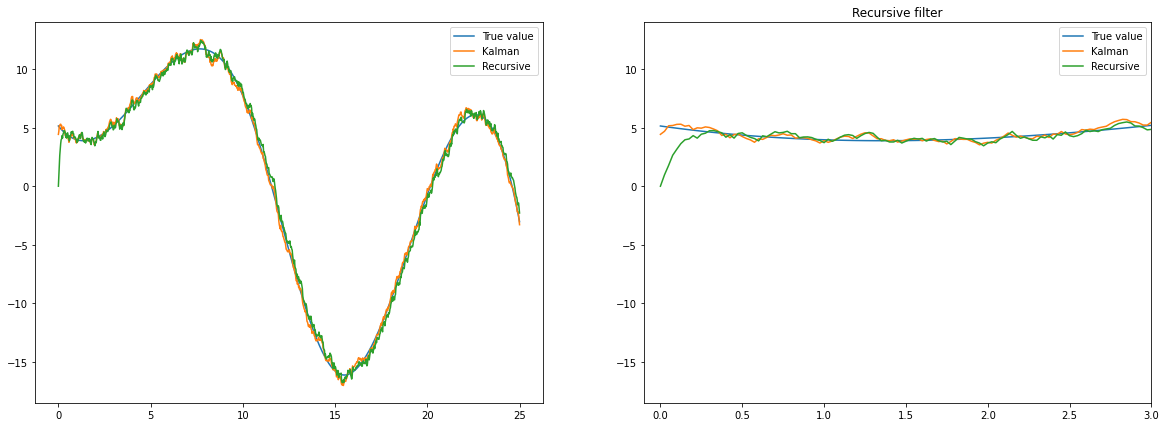

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
plt.title("Recursive filter")
ax[0].plot(xnew, spl(xnew), label="True value")
ax[0].plot(xnew, kalman[:, 0], label="Kalman")
ax[0].plot(xnew, recursive[:len(xnew)], label="Recursive")
ax[0].legend()

ax[1].plot(xnew, spl(xnew), label="True value")
ax[1].plot(xnew, kalman[:, 0], label="Kalman")
ax[1].plot(xnew, recursive[:len(xnew)], label="Recursive")
ax[1].legend()
ax[1].set_xlim((-0.1,3))

plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

print('kalman MSE:', mean_squared_error(spl(xnew), kalman[:, 0]))
print('recursive MSE:', mean_squared_error(spl(xnew), recursive[:len(xnew)]))

kalman MSE: 0.13956986420842193
recursive MSE: 0.2760474432662794


# Task 2.2

In [1]:
import pandas as pd
df = pd.read_csv('.eight_part1.csv', sep=',', dtype=float, decimal='.')
df = df[1:] #2st row has Latitude, Longtitude = 0
df

,Unnamed: 0,time,ax,ay,az,Latitude,Longitude,Speed (m/s)
1,1.0,0.091387,0.0000,0.0000,0.0000,55.753409,48.739783,0.00
2,2.0,0.120560,0.0000,0.0000,0.0000,55.753409,48.739783,0.00
3,3.0,0.134126,0.0000,0.0000,0.0000,55.753409,48.739783,0.00
4,4.0,0.135304,0.0000,0.0000,0.0000,55.753409,48.739783,0.00
5,5.0,0.144837,0.0000,0.0000,0.0000,55.753409,48.739783,0.00
...,...,...,...,...,...,...,...,...
22770,22770.0,185.997849,0.7210,-2.2604,1.0485,55.753097,48.741079,1.81
22771,22771.0,186.016178,0.7210,-2.2604,1.0485,55.753097,48.741079,1.81
22772,22772.0,186.020764,1.1592,-1.7141,-3.0830,55.753097,48.741079,1.81
22773,22773.0,186.023495,1.1592,-1.7141,-3.0830,55.753097,48.741079,1.81


In [2]:
!pip install folium

In [3]:
import folium

m = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=100)

trail = folium.PolyLine(
    locations=df[['Latitude', 'Longitude']].values,
    weight=2,
    color='red'
).add_to(m)

m

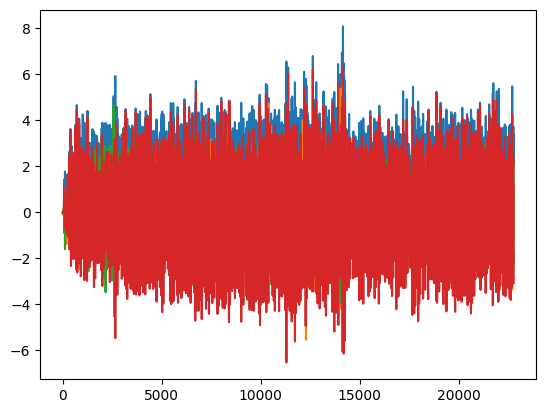

In [4]:
import matplotlib.pyplot as plt
import numpy as np
total_acc = np.sqrt((df['ax']**2) + (df['ay']**2) + (df['az']**2)).values
# horizontal_acc
plt.plot(total_acc)
plt.plot(df['ax'])
plt.plot(df['ay'])
plt.plot(df['az'])
# print(df['ax'])

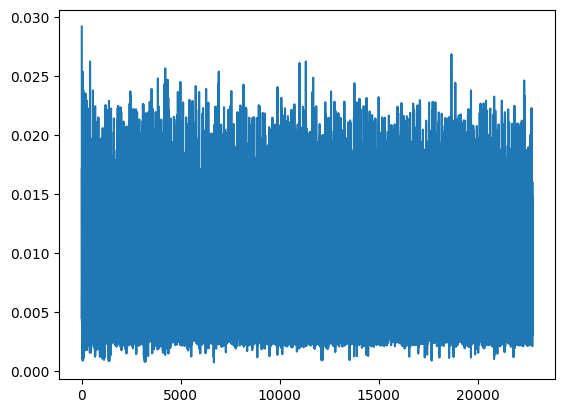

In [5]:
dt = np.gradient(df['time'])
plt.plot(dt)

In [57]:
from filterpy.kalman import KalmanFilter
import filterpy
filter = KalmanFilter(dim_x=9, dim_z=3)

# Observational matrix
filter.H = np.array([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                     [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]])

# Noise destribution
filter.R = np.diag([np.std(df['ax'])**2, np.std(df['ay'])**2, np.std(df['az'])**2])

# How little we trust initial estimation (larger number -> less trust)  # eOPt
filter.P = np.eye(9)*10

# Initial tate                                                          # xOpt
filter.x = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]) 


# filter.P

In [58]:
import scipy
f = lambda dt : np.array([[1,   dt,     (dt**2)/2],
                          [0,   1.0,    dt],
                          [0,   0,      1.0]])
F = lambda dt : scipy.linalg.block_diag(*([f(dt)]*3))

q = lambda dt : filterpy.common.Q_discrete_white_noise(dim=3, dt=dt) 
Q = lambda dt : scipy.linalg.block_diag(*([q(dt)]*3))

In [59]:
kalman = []
stateCovarianceHistory = []

for i in range(0, len(total_acc)):
   z = [ df['ax'].values[i],
         df['ay'].values[i],
         df['az'].values[i]]                         # Вектор измерений
   filter.predict(F=F(dt[i]), Q=Q(dt[i]))       # Этап предсказания Q=Q(dt[i]), 
   filter.update(z)     # Этап коррекции

   kalman.append(filter.x)
   stateCovarianceHistory.append(filter.P)

kalman = np.array(kalman)
stateCovarianceHistory = np.array(stateCovarianceHistory)

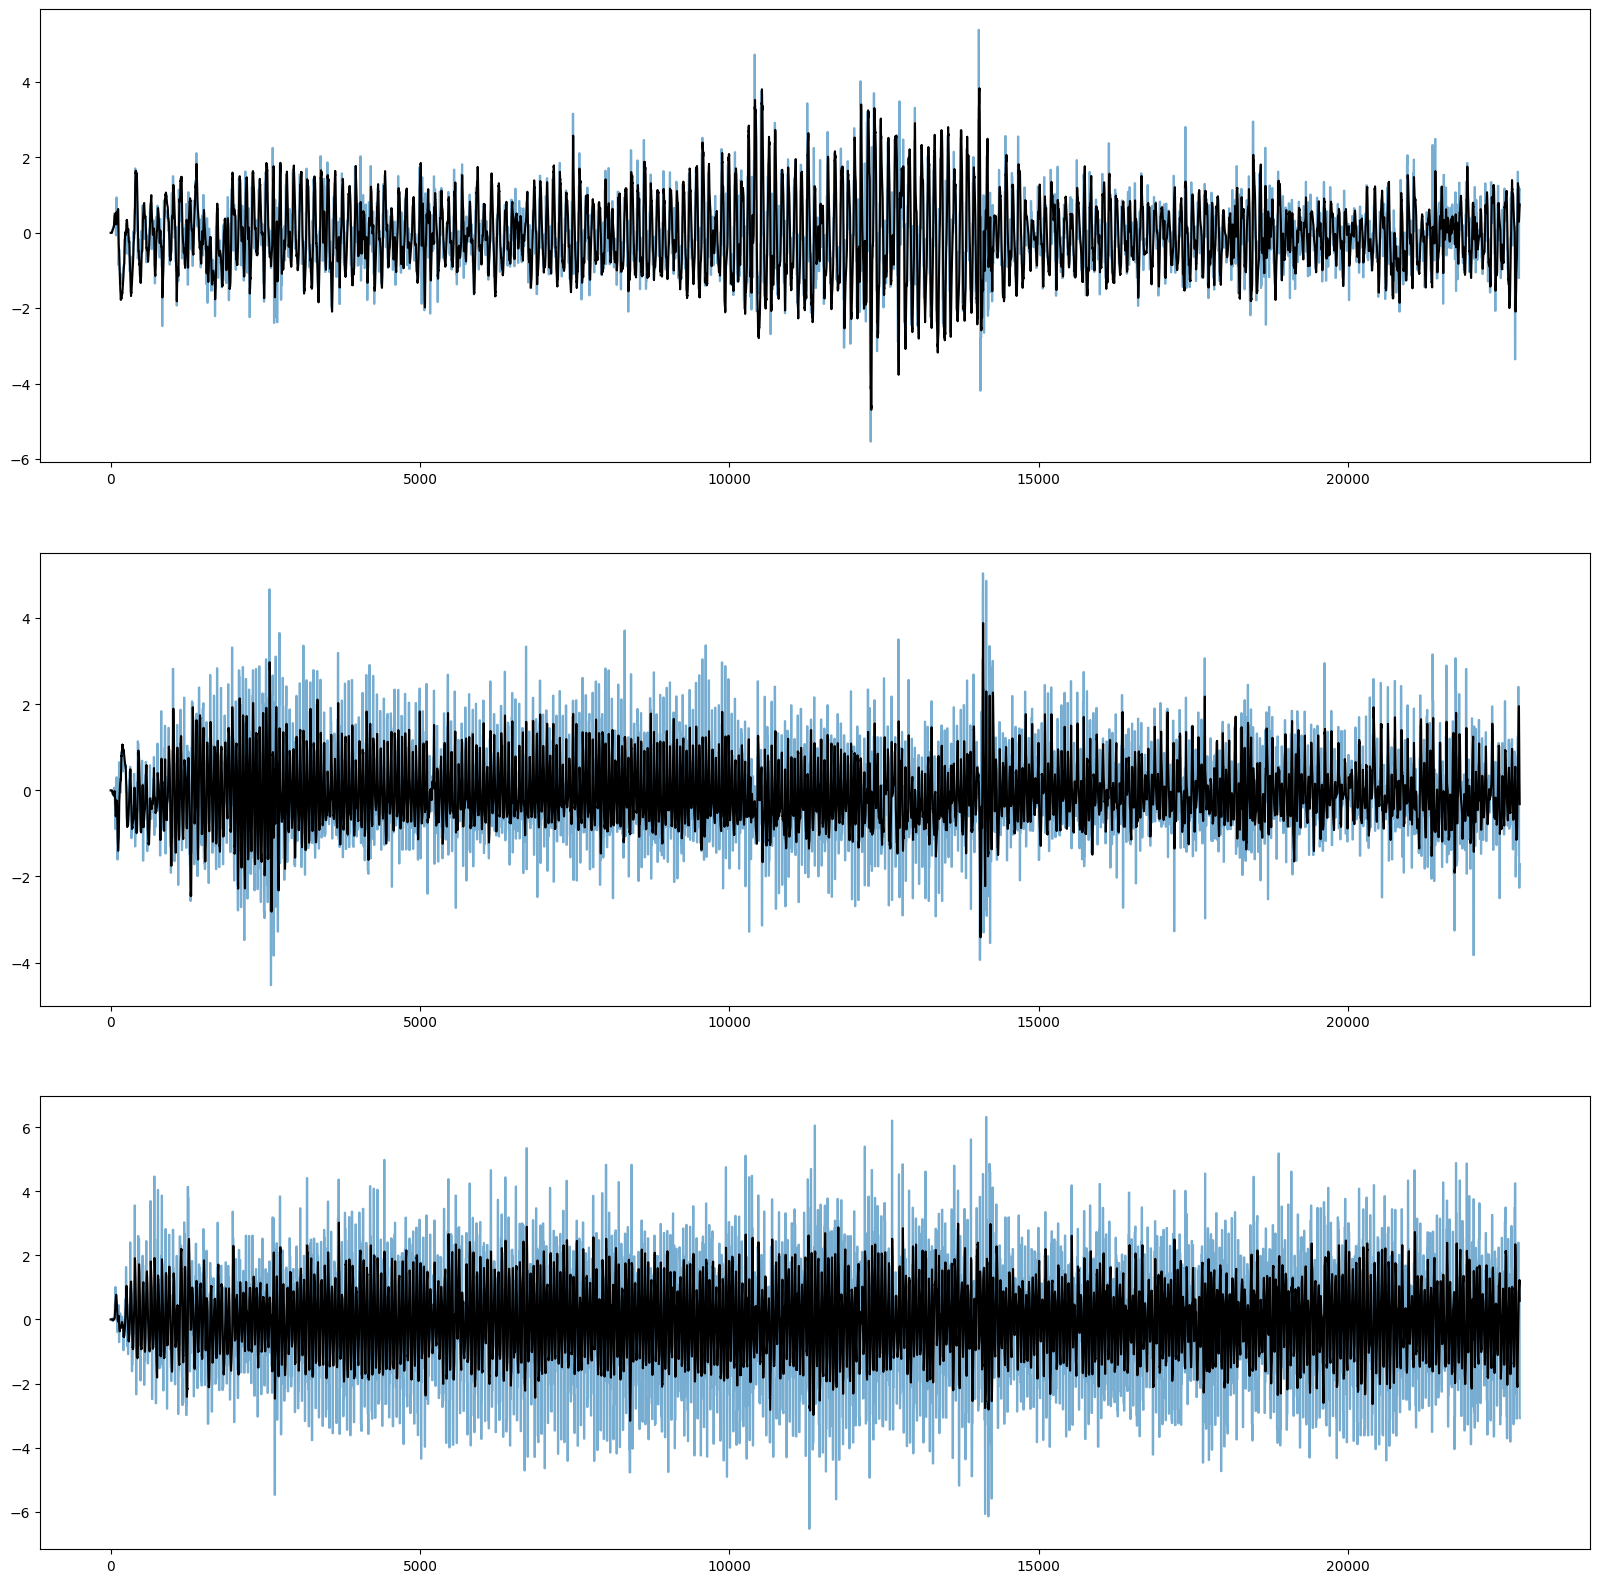

In [60]:
fig, ax = plt.subplots(3, 1, figsize=(20, 20))

ax[0].plot(df['ax'], alpha=0.6)
ax[1].plot(df['ay'], alpha=0.6)
ax[2].plot(df['az'], alpha=0.6)

ax[0].plot(kalman[:,0], 'k')
ax[1].plot(kalman[:,3], 'k')
ax[2].plot(kalman[:,6], 'k')

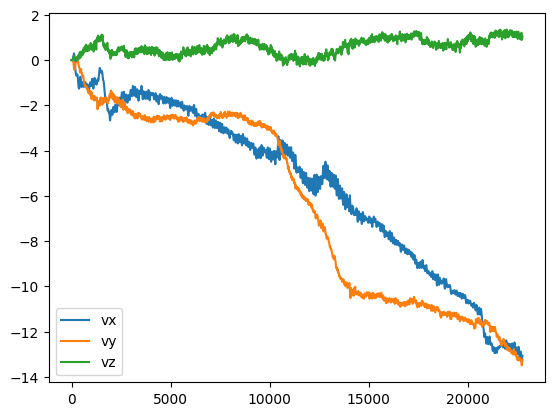

In [61]:
vx = np.cumsum(kalman[:,0] * dt, axis=0)
vy = np.cumsum(kalman[:,3] * dt, axis=0)
vz = np.cumsum(kalman[:,6] * dt, axis=0)
plt.plot(vx, label="vx")
plt.plot(vy, label="vy")
plt.plot(vz, label="vz")
plt.legend()

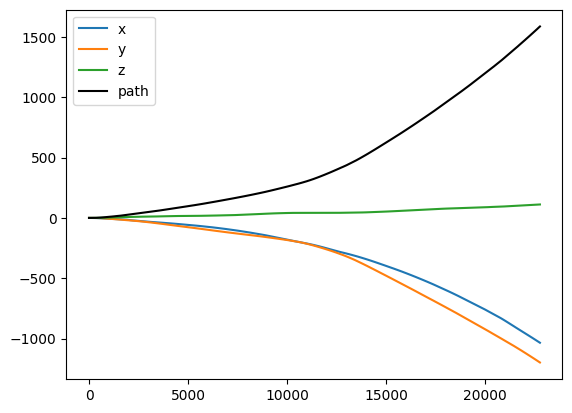

In [62]:
x = np.cumsum(vx * dt, axis=0)
y = np.cumsum(vy * dt, axis=0)
z = np.cumsum(vz * dt, axis=0)
path = np.sqrt(x**2 + y**2 + z**2)
plt.plot(x, label="x")
plt.plot(y, label="y")
plt.plot(z, label="z")
plt.plot(path, 'k', label="path")
plt.legend()